## Импорт модулей

In [1]:
# Работа с многомерными массивами
import numpy as np

# магическая команда для включения интерактивного режима
%matplotlib notebook 

# Визуализация расчетов
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.widgets import Slider

## Постановка задачи

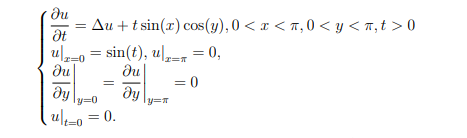

## Шаблон разностной схемы

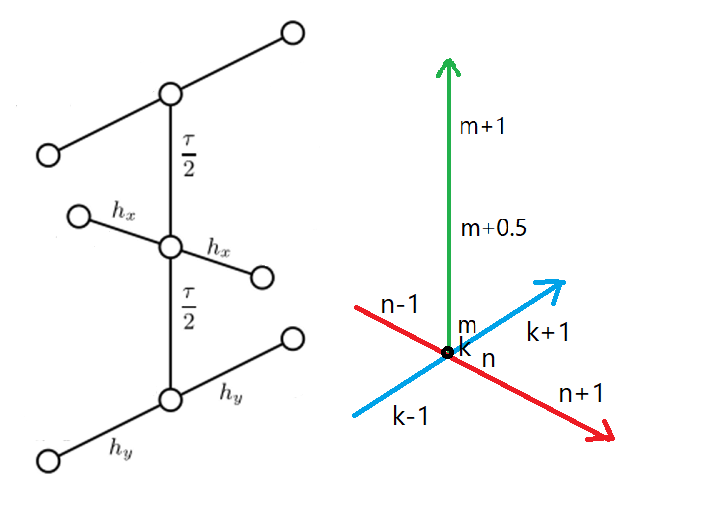

In [2]:
# Глобальные переменные (границы области)
T_min, T_max = 0, 10
X_min, X_max = 0, np.pi 
Y_min, Y_max = 0, np.pi 

## Аналитическое решение

In [3]:
def series_sum(t, x, eps=10**-5):
    def series_term(n):
        return 2*np.sin(n*x)*(n*(np.exp(-n*n*t)-np.cos(t))-np.sin(t)/n)/(np.pi*(1+n**4))
    
    result = series_term(2)
    previous_result = 0
    n = 3
    
    while((result-previous_result)>=eps):
        previous_result = result
        result+=series_term(n)
        n+=1
    return result
    
def analytic_point_solver(t, x, y):
    if (t==0):
        return 0
    if (x==0):
        return np.sin(t)
    if (x==np.pi):
        return 0
    result = (2*t - 1 + np.exp(-2*t))*np.sin(x)*np.cos(y)/4
    result += series_sum(t, x) + np.sin(t)*(1-x/np.pi)
    return result


def full_analytic_solver(M, N, K):
    
    # Массивы коордиант
    T = np.linspace(T_min, T_max, M)
    X = np.linspace(X_min, X_max, N)
    Y = np.linspace(Y_min, Y_max, K)
    
    # шаги сетки
    tau = np.abs(float((T_max - T_min)/(M-1)))
    h_x = np.abs(float((X_max - X_min)/(N-1)))   
    h_y = np.abs(float((Y_max - Y_min)/(K-1))) 
    
    u_analytic = np.zeros((M,N,K), dtype=float) # инициализация аналитического решения
    
    
    for i in range(0, M):
        for j in range(0, N):
            for k in range(0, K):
                u_analytic[i, j, k] = analytic_point_solver(i*tau, j*h_x, k*h_y)
            
    return [u_analytic, T, X, Y]     

In [4]:
M1,N1,K1 = 1200,20,20
[u_analytic, T, X, Y] = full_analytic_solver(M1, N1, K1)

<IPython.core.display.Javascript object>


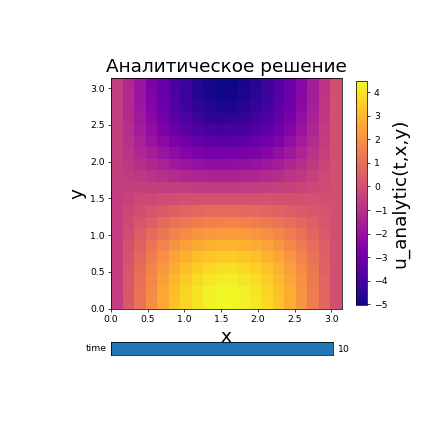

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

im = plt.imshow(np.rot90(u_analytic[0]), 
                vmin=u_analytic.min(), 
                vmax=u_analytic.max(), 
                cmap = 'plasma', 
                extent=[X_min,X_max,Y_min,Y_max])

ax.set_ylabel(r'y',fontsize=20)
ax.set_xlabel(r'x',fontsize=20)

clb=fig.colorbar(im, ax=ax, shrink=0.8, 
                 ticks=np.linspace(int(u_analytic.min()),
                                   int(u_analytic.max()),
                                   1+int(u_analytic.max())-int(u_analytic.min())))

clb.set_label(r'u_analytic(t,x,y)',fontsize=20)

plt.title('Аналитическое решение', fontsize=20)
plt.subplots_adjust(left=0.25, bottom=0.25)

axtime = plt.axes([0.25, 0.2, 0.5, 0.03])

tau = np.abs(float((T_max - T_min)/(M1-1)))

time = Slider(axtime, 'time', T_min, T_max, T_min, valstep=tau)

def update(val):
    t = time.val
    im.set_data(np.rot90(u_analytic[int(t/tau)]))
    
time.on_changed(update)
plt.show()

<IPython.core.display.Javascript object>


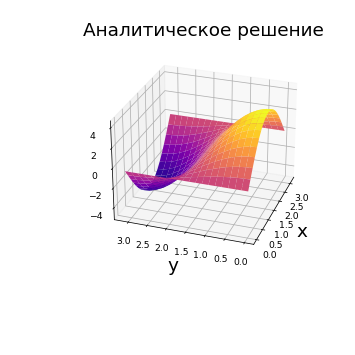

In [6]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8))

x_mesh, y_mesh = np.meshgrid(X,Y)

surf = ax.plot_surface(y_mesh, x_mesh, u_analytic[int(T_max/tau)], cmap='plasma')
plt.title('Аналитическое решение', fontsize=20)
plt.subplots_adjust(left=0.25, bottom=0.25)
ax.set_ylabel(r'y',fontsize=20)
ax.set_xlabel(r'x',fontsize=20)
plt.show()

## Метод прогонки

In [7]:
def TDMA(A, C, B, F, kappa_1, mu_1, kappa_2, mu_2): 
    """Метод прогонки.""" 
    
    x = np.zeros(F.shape[0])
    
    alpha = np.zeros(F.shape[0])
    beta = np.zeros(F.shape[0])
    alpha[1]=kappa_1
    beta[1]=mu_1
    
    for i in range(2, F.shape[0]):
        alpha[i] = B/(C - alpha[i-1]*A)
        beta[i] = (A*beta[i-1]+F[i-1])/(C - alpha[i-1]*A)
    
    x[-1] = (mu_2 + kappa_2*beta[-1])/(1-kappa_2*alpha[-1])

    for i in range(F.shape[0]-2, -1, -1):
        x[i] = alpha[i+1]*x[i+1] + beta[i+1]

    return x

## Численное решение

In [8]:
def numeric_solver(M, N, K):
    T = np.linspace(T_min, T_max, M)
    X = np.linspace(X_min, X_max, N)
    Y = np.linspace(Y_min, Y_max, K)
    
    tau = np.abs(float((T_max - T_min)/(M-1)))
    h_x = np.abs(float((X_max - X_min)/(N-1)))   
    h_y = np.abs(float((Y_max - Y_min)/(K-1))) 
    
    
    x_arr = np.arange(N)
    y_arr = np.arange(K)
    t_arr = np.arange(M)
    
    u = np.zeros((M,N,K), dtype=float) 
    u_ = np.zeros((M,N,K), dtype=float)
    
    gr_x_0 = np.sin(t_arr*tau)
    u[t_arr, 0] = gr_x_0[t_arr, np.newaxis]
    
    def F1(m,k):
        result = (m)*tau*np.sin(x_arr*h_x)*np.cos(k*h_y)
        result += (u[m-1,x_arr, k-1] + u[m-1,x_arr, k+1])/h_y**2
        result += u[m-1, x_arr, k]*2*(1/tau - 1/h_y**2)
        return (h_x**2)*result
    
    
    def F2(m,n):
            result = (m+0.5)*tau*np.sin(n*h_x)*np.cos(y_arr*h_y)
            result += (u_[m, n-1, y_arr] + u_[m, n+1, y_arr])/h_x**2
            result += u_[m, n, y_arr]*2*(1/tau - 1/h_x**2)
            return (h_y**2)*result
    
    
    for m in range(1, M):
        for k in range(0, K-1):
            u_[m, x_arr, k] = TDMA(1, 2*(1 + h_x*h_x/tau), 1, F1(m,k), 0, np.sin((m+0.5)*tau), 0, 0)
        
        for n in range(1, N-1):
            u[m, n, y_arr] = TDMA(1, 2*(1 + h_y*h_y/tau), 1, F2(m,n), 1, 0, 1, 0)
    
    u[m, x_arr, K-1] = u[m, x_arr, K-2] 
    u[m, x_arr, 0] = u[m, x_arr, 1]
    return u

In [9]:
u = numeric_solver(M1,N1,K1)
delta_u = np.abs(u-u_analytic)

<IPython.core.display.Javascript object>


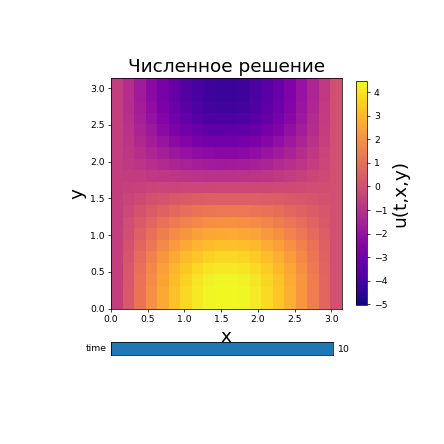

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

im = plt.imshow(np.rot90(u[0]), 
                   vmin=u_analytic.min(), vmax=u_analytic.max(), cmap = 'plasma', extent=[X_min,X_max,Y_min,Y_max])

ax.set_ylabel(r'y',fontsize=20)
ax.set_xlabel(r'x',fontsize=20)

clb=fig.colorbar(im, ax=ax, shrink=0.8, 
                 ticks=np.linspace(int(u_analytic.min()),int(u_analytic.max()),1+int(u_analytic.max())-int(u_analytic.min())))
clb.set_label(r'u(t,x,y)',fontsize=20)

plt.title('Численноe решение', fontsize=20)
plt.subplots_adjust(left=0.25, bottom=0.25)

axtime = plt.axes([0.25, 0.2, 0.5, 0.03])

tau = np.abs(float((T_max - T_min)/(M1-1)))

time = Slider(axtime, 'time', T_min, T_max, T_min, valstep=tau)

def update(val):
    t = time.val
    im.set_data(np.rot90(u[int(t/tau)]))
    
time.on_changed(update)
plt.show()

<IPython.core.display.Javascript object>


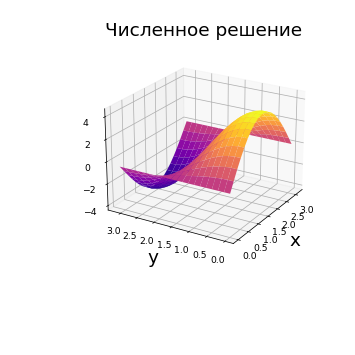

In [12]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8))

x_mesh, y_mesh = np.meshgrid(X,Y)
surf = ax.plot_surface(y_mesh, x_mesh, u[int(T_max/tau)], cmap='plasma')
plt.title('Численное решение', fontsize=20)
plt.subplots_adjust(left=0.25, bottom=0.25)
ax.set_ylabel(r'y',fontsize=20)
ax.set_xlabel(r'x',fontsize=20)
plt.show()

## Сравнение численного и аналитического решений

<IPython.core.display.Javascript object>


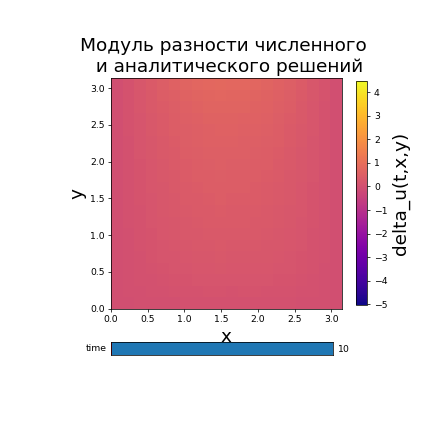

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

im = plt.imshow(np.rot90(delta_u[0]), 
                   vmin=u_analytic.min(), vmax=u_analytic.max(), cmap = 'plasma', extent=[X_min,X_max,Y_min,Y_max])

ax.set_ylabel(r'y',fontsize=20)
ax.set_xlabel(r'x',fontsize=20)

clb=fig.colorbar(im, ax=ax, shrink=0.8, 
                 ticks=np.linspace(int(u_analytic.min()),int(u_analytic.max()),1+int(u_analytic.max())-int(u_analytic.min())))
clb.set_label(r'delta_u(t,x,y)',fontsize=20)

plt.title('Модуль разности численного \n и аналитического решений', fontsize=20)
plt.subplots_adjust(left=0.25, bottom=0.25)

axtime = plt.axes([0.25, 0.2, 0.5, 0.03])

tau = np.abs(float((T_max - T_min)/(M1-1)))

time = Slider(axtime, 'time', T_min, T_max, T_min, valstep=tau)

def update(val):
    t = time.val
    im.set_data(np.rot90(delta_u[int(t/tau)]))
    
time.on_changed(update)
plt.show()